In [5]:
# Import libraries
import torch
import pandas as pd
import numpy as np
import os

# 1. Connecting to CUDA Grünau

Run on GPU, because running it on CPU will cost a lot of time (during my experiments, it exeeds 8 hours).


I do not recommend to run it in Google Colab, because it interrupts training process.

If you are not going to use remote servers with multiple GPUs (e. g. Grünau servers), skip this part.

In [6]:
# For gruenau: For CUDA making it available this works:
# pip3 install torch torchvision torchaudio

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [7]:
# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print("Number of available GPUs:", num_gpus)

Number of available GPUs: 3


In [8]:
torch.cuda.get_device_name(1)

'Tesla V100-PCIE-32GB'

In [9]:
# Index of the GPU you want to use (e.g., 0, 1, 2, etc.)
# Choose that one that is not used by other processes
gpu_index = "1"

# 2. Informer

In [2]:
import os

# Define the path to your script
script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Define the command with arguments (without redirection to a log file)
command = f"""
python {script_path} \
  --random_seed 2021 \
  --is_training 1 \
  --root_path "/vol/cs-hu/riabchuv/my_work/datasets/" \
  --data_path "GB_data_small.csv" \
  --model_id 1 \
  --model "Informer" \
  --model_id test_20_10 \
  --data "custom" \
  --features M \
  --seq_len 20 \
  --label_len 5 \
  --pred_len 10 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 5 \
  --dec_in 5 \
  --c_out 5 \
  --des 'Exp' \
  --train_epochs 1 \
  --patience 1 \
  --patch_len 3 \
  --stride 2 \
  --n_heads 16 \
  --d_model 128 \
  --d_ff 256 \
  --dropout 0.2 \
  --fc_dropout 0.2 \
  --head_dropout 0 \
  --itr 1 --batch_size 2 --learning_rate 0.0001
"""

# Execute the command and display output in the notebook
!{command}

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='test_20_10', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='GB_data_small.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=20, label_len=5, pred_len=10, fc_dropout=0.2, head_dropout=0.0, patch_len=3, stride=2, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=128, n_heads=16, e_layers=2, d_layers=1, d_ff=256, moving_avg=25, factor=3, distil=True, dropout=0.2, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=1, batch_size=2, patience=1, learning_rate=0.0001, des='Exp', loss='mse', lradj='type3', pct_start=0.3, use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', test_flop=False)
Use GPU: cuda:0
>>>>>>>start training : test_20_10_Informer_custom_ftM_

In [3]:
import os

# Define dynamic variables
pred_len = 10
seq_len = 20
model_id_name = "test"

# Define the path to your script
script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Define the log file path (dynamically use the variables)
log_file = f"logs/LongForecasting/Informer_{model_id_name}_{seq_len}_{pred_len}.log"

# Construct the command using the variables
command = f"""
python {script_path} \
  --random_seed 2021 \
  --is_training 1 \
  --root_path "/vol/cs-hu/riabchuv/my_work/datasets/" \
  --data_path "GB_data_small.csv" \
  --model_id 1 \
  --model "Informer" \
  --model_id {model_id_name}_{seq_len}_{pred_len} \
  --data "custom" \
  --features M \
  --seq_len {seq_len} \
  --label_len 5 \
  --pred_len {pred_len} \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 5 \
  --dec_in 5 \
  --c_out 5 \
  --des 'Exp' \
  --train_epochs 1 \
  --patience 1 \
  --patch_len 3 \
  --stride 2 \
  --n_heads 16 \
  --d_model 128 \
  --d_ff 256 \
  --dropout 0.2 \
  --fc_dropout 0.2 \
  --head_dropout 0 \
  --itr 1 --batch_size 2 --learning_rate 0.0001 > {log_file}
"""

# Run the command
os.system(command)

# Optionally, display the content of the log file
with open(log_file, 'r') as f:
    print(f.read())

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='test_20_10', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='GB_data_small.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=20, label_len=5, pred_len=10, fc_dropout=0.2, head_dropout=0.0, patch_len=3, stride=2, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=128, n_heads=16, e_layers=2, d_layers=1, d_ff=256, moving_avg=25, factor=3, distil=True, dropout=0.2, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=1, batch_size=2, patience=1, learning_rate=0.0001, des='Exp', loss='mse', lradj='type3', pct_start=0.3, use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', test_flop=False)
Use GPU: cuda:0
>>>>>>>start training : test_20_10_Informer_custom_ftM_

In [6]:
import numpy as np
np.sqrt(2.2094132900238037)

1.4864095297137339

In [17]:
current_path = os.getcwd() + "/datasets/"
dataset = 'GB_data_small.csv'
data = "custom"
random_seed=2021
model_name="Informer"
seq_len=20
model_id_name="test"
pred_len=10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


!python -u ./PatchTST-main/PatchTST_supervised/run_longExp.py \
  --random_seed 2021 \
  --is_training 1 \
  --root_path "/vol/cs-hu/riabchuv/my_work/datasets/" \
  --data_path "GB_data_small.csv" \
  --model_id 1 \
  --model "Informer" \
  --model_id $model_id_name_$seq_len'_'$pred_len \
  --data "custom" \
  --features M \
  --seq_len 20 \
  --label_len 5 \
  --pred_len 10 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 5 \
  --dec_in 5 \
  --c_out 5 \
  --des 'Exp' \
  --train_epochs 1\
  --patience 1\
  --patch_len 3\
  --stride 2\
  --n_heads 16 \
  --d_model 128 \
  --d_ff 256 \
  --dropout 0.2\
  --fc_dropout 0.2\
  --head_dropout 0\
  --itr 1 --batch_size 2 --learning_rate 0.0001 >logs/LongForecasting/$model_name'_'$model_id_name'_'$seq_len'_'$pred_len.log

In [16]:
current_path = os.getcwd() + "/datasets/"
dataset = 'GB_data_small.csv'
data = "custom"
random_seed=2021
model_name="PatchTST"
seq_len=20
model_id_name="test"
pred_len=10

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


!python -u ./PatchTST-main/PatchTST_supervised/run_longExp.py \
  --random_seed 2021 \
  --is_training 1 \
  --root_path "/vol/cs-hu/riabchuv/my_work/datasets/" \
  --data_path "GB_data_small.csv" \
  --model_id 1 \
  --model "PatchTST" \
  --model_id $model_id_name_$seq_len'_'$pred_len \
  --data "custom" \
  --features M \
  --seq_len 20 \
  --label_len 5 \
  --pred_len 10 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 5 \
  --dec_in 5 \
  --c_out 5 \
  --des 'Exp' \
  --train_epochs 1\
  --patience 1\
  --patch_len 3\
  --stride 2\
  --n_heads 16 \
  --d_model 128 \
  --d_ff 256 \
  --dropout 0.2\
  --fc_dropout 0.2\
  --head_dropout 0\
  --itr 1 --batch_size 2 --learning_rate 0.0001 >logs/LongForecasting/$model_name'_'$model_id_name'_'$seq_len'_'$pred_len.log

In [10]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'GB_data_small.csv'

!python -u ./PatchTST-main/PatchTST_supervised/run_longExp.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 5 \
  --dec_in 5 \
  --c_out 5 \
  --des 'Exp' \
  --itr 2

usage: run_longExp.py [-h] [--random_seed RANDOM_SEED] --is_training
                      IS_TRAINING --model_id MODEL_ID --model MODEL --data
                      DATA [--root_path ROOT_PATH] [--data_path DATA_PATH]
                      [--features FEATURES] [--target TARGET] [--freq FREQ]
                      [--checkpoints CHECKPOINTS] [--seq_len SEQ_LEN]
                      [--label_len LABEL_LEN] [--pred_len PRED_LEN]
                      [--fc_dropout FC_DROPOUT] [--head_dropout HEAD_DROPOUT]
                      [--patch_len PATCH_LEN] [--stride STRIDE]
                      [--padding_patch PADDING_PATCH] [--revin REVIN]
                      [--affine AFFINE] [--subtract_last SUBTRACT_LAST]
                      [--decomposition DECOMPOSITION]
                      [--kernel_size KERNEL_SIZE] [--individual INDIVIDUAL]
                      [--embed_type EMBED_TYPE] [--enc_in ENC_IN]
                      [--dec_in DEC_IN] [--c_out C_OUT] [--d_model D_MODEL]
           

In [7]:
# Create a folder named "datasets" if it doesn't exist
folder_name = "datasets"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

df = pd.read_csv("./datasets/top_5_countries.csv", index_col=0, parse_dates=True)
# Reset index for Data Loader
df.reset_index(inplace=True)
df = df.iloc[:,:-6]

In [3]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']

# Split and save the datasets
for country_prefix in top_5_countries:
    # Filter columns with the specified prefix
    country_columns = [col for col in df.columns if col.startswith(country_prefix)]
    
    # Insert the date column at the beginning of every dataset
    country_columns.insert(0,"date")
    country_df = df[country_columns]
    
    # Save the DataFrame to a CSV file
    file_name = f"./datasets/{country_prefix}_data.csv"
    country_df.to_csv(file_name, index=False)


# Distribution

In [6]:
train=28321
val=6577
test=8713

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
def split_scale_dataset(data, train_size, val_size, test_size=None):

    """
    data (pd.DataFrame): Dataframe with time series data.
    train_size, test_size, val_size (int): number of days in train, 
                                            test and validation datasets.

    return: Scaled datasets
   
    
    num_train = train_size*24
    if test_size is not None:
        num_test = test_size*24
    num_vali = val_size*24
"""
    num_train = train_size
    num_vali = val_size
    train_data = data.iloc[:num_train] # 0, a-1
    vali_data = data.iloc[num_train: num_train + num_vali] # a, a+b-1
    test_data = data.iloc[num_train + num_vali:] # a+b

    assert(len(data) == len(train_data) + len(test_data) + len(vali_data))

    print(f'{len(train_data)} observations in the train dataset.\n {len(test_data)} observations in the test dataset.\n {len(vali_data)} observations in the validation dataset.')

    # initialize scaler object
    scaler = StandardScaler()

    # scale data
    train_data_sc = scaler.fit_transform(train_data)
    vali_data_sc = scaler.transform(vali_data)
    test_data_sc = scaler.transform(test_data)

    train_data_sc = pd.DataFrame(train_data_sc, columns=train_data.columns, index=train_data.index)
    vali_data_sc = pd.DataFrame(vali_data_sc, columns=vali_data.columns, index=vali_data.index)
    test_data_sc = pd.DataFrame(test_data_sc, columns=test_data.columns, index=test_data.index)

    return train_data_sc, vali_data_sc, test_data_sc

#time_series = pd.read_csv("./datasets/df_most_important_columns.csv", index_col=0, parse_dates=True)
#train, vali, test = split_scale_dataset(data=time_series, train_size=train, val_size=val)

<Axes: xlabel='DE_load_actual_entsoe_transparency', ylabel='Count'>

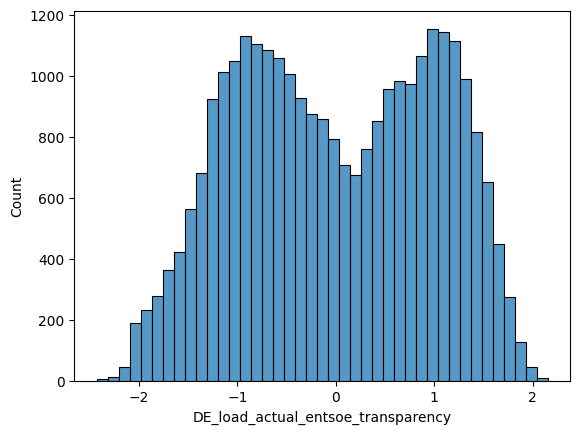

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(train["DE_load_actual_entsoe_transparency"])

In [15]:
train.describe().round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
count,28321.00,28321.00,28321.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.43,-0.64,-1.24
25%,-0.84,-0.64,-0.77
50%,-0.03,-0.63,-0.29
75%,0.89,0.37,0.52
max,2.16,3.94,3.99


<Axes: xlabel='DE_load_actual_entsoe_transparency', ylabel='Count'>

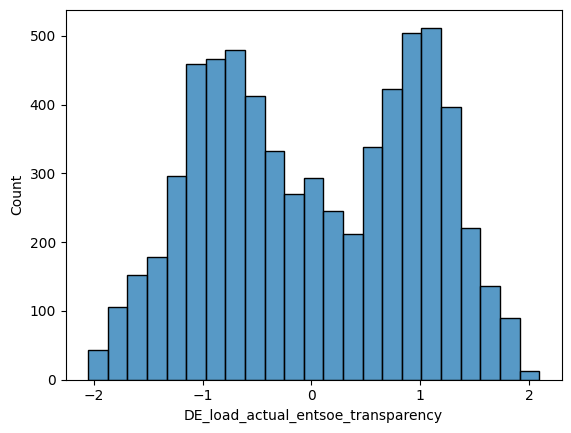

In [9]:
sns.histplot(vali["DE_load_actual_entsoe_transparency"])

In [16]:
vali.describe().round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
count,6577.00,6577.00,6577.00
mean,0.03,0.27,0.14
std,0.97,1.29,1.03
min,-2.05,-0.64,-1.21
25%,-0.82,-0.64,-0.64
50%,-0.01,-0.56,-0.14
75%,0.91,1.05,0.65
max,2.09,4.16,4.24


<Axes: xlabel='DE_load_actual_entsoe_transparency', ylabel='Count'>

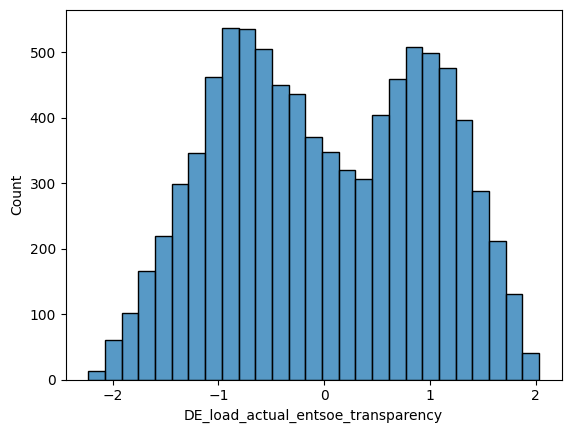

In [10]:
sns.histplot(test["DE_load_actual_entsoe_transparency"])

In [17]:
test.describe().round(2)

,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
count,8895.00,8895.00,8895.00
mean,0.01,0.14,0.49
std,0.98,1.20,1.22
min,-2.23,-0.64,-1.20
25%,-0.81,-0.64,-0.46
50%,-0.05,-0.62,0.18
75%,0.87,0.59,1.14
max,2.03,4.34,4.30


# Distribution ETTH1

In [6]:
import pandas as pd
time_series = pd.read_csv("./datasets/ETTh1.csv", index_col=0, parse_dates=True)
train, vali, test = split_scale_dataset(data=time_series, train_size=8521, val_size=2857)

8521 observations in the train dataset.
 6042 observations in the test dataset.
 2857 observations in the validation dataset.


In [24]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17420 entries, 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float64
 1   HULL    17420 non-null  float64
 2   MUFL    17420 non-null  float64
 3   MULL    17420 non-null  float64
 4   LUFL    17420 non-null  float64
 5   LULL    17420 non-null  float64
 6   OT      17420 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [ ]:
17420

In [25]:
8521 + 2857 + 2857

14235

In [33]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'ETTh1.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 7 \
  --dec_in 7 \
  --c_out 7 \
  --des 'Exp' \
  --itr 2

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8569
val 4345
test 4321
	iters: 100, epoch: 1 | loss: 0.4733695
	speed: 0.0626s/iter; left time: 160.8995s
	iters: 200, epoch: 1 | loss: 0.3275512
	speed: 0.0413s/iter; left time: 102.0419s
Epoch: 1 running time: 0.20149732033411663 min.
Epoch: 1, Steps: 267 | Train Loss: 0.4435941 Vali Loss: 0.6720330 Test Loss: 0.7471600
Validation loss decreased (inf --> 0.672033).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.3207772
	speed: 0.1169s/iter; left time: 269.3744s
	iters: 200, epoch: 2 | loss: 0.3147012
	speed: 0.0416s/iter; left time: 91.7787s
Epoch: 2 running time: 0.18970996936162313 min.
Epoch: 2, Steps: 267 | Train Loss: 0.3283183 Vali Loss: 0.6654594 Test Loss: 0.8112167
Validation loss decreased (0.672033 --> 0.665459).  Saving model ...
Updating learning rate to 5e-05

# 2. Informer

In [13]:
"""
# https://colab.research.google.com/drive/1rv2rKwQqgoHDNjXtRoAEWZ2ATz0gGAKu?usp=sharing#scrollTo=yu6zzic9t_Cz
# Popen: https://colab.research.google.com/github/aviadr1/learn-python/blob/master/content/13_multiprocessing/notebooks/os_system_subprocess.ipynb
import subprocess
import os
# parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_to_run_file = "./TSLibrary/run.py"

def run_output(path_to_run_file, model_arguments):
    try:
        # Execute the script and capture the output
        command = ["python", "-u", path_to_run_file] + model_arguments
        output = subprocess.check_output(command, universal_newlines=True)
    except subprocess.CalledProcessError as e:
        output = e.output  

    return output
"""

In [ ]:
"""
import subprocess
import os
# parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_to_run_file = "/content/my_work/TSLibrary/run.py"

def run_output(path_to_run_file, model_arguments):
    try:
        # Define command and options wanted
        command = "python"
        options = "-u"
        # Run the shell command directly in Colab
        output = !{command} {options} {path_to_run_file} {model_arguments}

    except subprocess.CalledProcessError as e:
        output = e.output

    return output

def run_output(path_to_run_file, model_arguments):
    try:
        # Execute the script using the %run magic command
        output = %run -i {path_to_run_file} {model_arguments}

    except Exception as e:
        output = str(e)

    return output
"""

In [8]:
# Seems to work in colab
import subprocess

path_to_run_file = "./TSLibrary/run.py"

def run_output(path_to_run_file, model_arguments):
    try:
        # Construct the command to execute the script with required and model arguments
        command = ["python", "-u", path_to_run_file] + model_arguments
        # Execute the script and capture the output
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        # Check if there's any error in the process
        if process.returncode != 0:
            output = stderr.decode("utf-8")
        else:
            output = stdout.decode("utf-8")
    except Exception as e:
        output = str(e)
    return output

In [5]:
import os
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'
script_arguments = [
    "--task_name", "long_term_forecast",
    "--is_training", "1",
    "--root_path", current_path,
    "--data_path", dataset,
    "--model_id", "1",
    "--model", "Informer",
    "--data", "custom",
    "--features", "M",
    "--seq_len", "96",
    "--label_len", "48",
    "--pred_len", "24",
    "--e_layers", "2",
    "--d_layers", "5",
    "--factor", "5",
    "--enc_in", "3",
    "--dec_in", "3",
    "--c_out", "3",
    "--des", "Exp",
    "--itr", "2"
]

model_output = run_output(path_to_run_file, script_arguments)

#folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
folder_path = f'./results/{"Informer"}/'

# Write model output into txt file
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output_chr.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

print(model_output)

end = time.time()
print("Total time:", (end - start)/60, "min.")

KeyboardInterrupt: 

In [1]:
import pandas as pd
pd.read_csv('./datasets/df_most_important_columns.csv')

,date,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual
0,2015-01-01 07:00:00,41133.0,71.0,10208.0
1,2015-01-01 08:00:00,42963.0,773.0,10029.0
2,2015-01-01 09:00:00,45088.0,2117.0,10550.0
3,2015-01-01 10:00:00,47013.0,3364.0,11390.0
4,2015-01-01 11:00:00,48159.0,4198.0,12103.0
...,...,...,...,...
43788,2019-12-30 19:00:00,53959.0,0.0,32323.0
43789,2019-12-30 20:00:00,51937.0,0.0,32395.0
43790,2019-12-30 21:00:00,50574.0,0.0,31439.0
43791,2019-12-30 22:00:00,47382.0,0.0,30727.0


In [28]:
28321 + 6577 + 8713

43611

In [25]:
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 2

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 28321
val 6577
test 8713
	iters: 100, epoch: 1 | loss: 0.4881925
	speed: 0.0612s/iter; left time: 535.5396s
	iters: 200, epoch: 1 | loss: 0.4415741
	speed: 0.0419s/iter; left time: 362.6325s
	iters: 300, epoch: 1 | loss: 0.4410460
	speed: 0.0412s/iter; left time: 351.9689s
	iters: 400, epoch: 1 | loss: 0.2902627
	speed: 0.0415s/iter; left time: 350.4010s
	iters: 500, epoch: 1 | loss: 0.3088942
	speed: 0.0412s/iter; left time: 343.8548s
	iters: 600, epoch: 1 | loss: 0.3044106
	speed: 0.0414s/iter; left time: 341.2761s
	iters: 700, epoch: 1 | loss: 0.2735647
	speed: 0.0421s/iter; left time: 342.8331s
	iters: 800, epoch: 1 | loss: 0.2792752
	speed: 0.0417s/iter; left time: 335.5625s
Epoch: 1 running time: 0.6292555173238118 min.
Epoch: 1, Steps: 885 | Train Loss: 0.3454897 Vali Loss: 0.2995675 Test Loss: 0.3626922

In [19]:
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  #--d_ff 256 \
  #--d_model 256 \
  --des 'Exp' \
  --itr 2

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 4321
test 8641
	iters: 100, epoch: 1 | loss: 0.7090327
	speed: 0.0694s/iter; left time: 653.2046s
	iters: 200, epoch: 1 | loss: 0.6357286
	speed: 0.0500s/iter; left time: 465.5139s
	iters: 300, epoch: 1 | loss: 0.5953805
	speed: 0.0505s/iter; left time: 464.7455s
	iters: 400, epoch: 1 | loss: 0.4663185
	speed: 0.0504s/iter; left time: 459.0093s
	iters: 500, epoch: 1 | loss: 0.4046238
	speed: 0.0505s/iter; left time: 455.3592s
	iters: 600, epoch: 1 | loss: 0.3477176
	speed: 0.0494s/iter; left time: 440.2458s
	iters: 700, epoch: 1 | loss: 0.4344813
	speed: 0.0500s/iter; left time: 440.9754s
	iters: 800, epoch: 1 | loss: 0.3226214
	speed: 0.0484s/iter; left time: 421.2105s
	iters: 900, epoch: 1 | loss: 0.3889300
	speed: 0.0482s/iter; left time: 415.0947s
Epoch: 1 running time: 0.8037162542343139 min.
Ep

# enc_layers = 2, d_layers = 1

In [5]:
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.7141522
	speed: 0.0572s/iter; left time: 538.7338s
	iters: 200, epoch: 1 | loss: 0.6334165
	speed: 0.0384s/iter; left time: 357.9389s
	iters: 300, epoch: 1 | loss: 0.5902387
	speed: 0.0393s/iter; left time: 361.8272s
	iters: 400, epoch: 1 | loss: 0.4588140
	speed: 0.0348s/iter; left time: 316.8726s
	iters: 500, epoch: 1 | loss: 0.4049430
	speed: 0.0388s/iter; left time: 349.9006s
	iters: 600, epoch: 1 | loss: 0.3436919
	speed: 0.0382s/iter; left time: 340.4654s
	iters: 700, epoch: 1 | loss: 0.4383478
	speed: 0.0384s/iter; left time: 338.2228s
	iters: 800, epoch: 1 | loss: 0.3165578
	speed: 0.0383s/iter; left time: 333.2159s
	iters: 900, epoch: 1 | loss: 0.3756514
	speed: 0.0384s/iter; left time: 330.3723s
Epoch: 1 running time: 0.6205641269683838 min.
Epo

# enc_layers = 2, d_layers = 2

In [6]:
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 2 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.5454894
	speed: 0.2071s/iter; left time: 1949.4369s
	iters: 200, epoch: 1 | loss: 0.4153013
	speed: 0.1876s/iter; left time: 1746.8217s
	iters: 300, epoch: 1 | loss: 0.3637479
	speed: 0.1845s/iter; left time: 1699.0011s
	iters: 400, epoch: 1 | loss: 0.3130654
	speed: 0.1870s/iter; left time: 1703.5923s
	iters: 500, epoch: 1 | loss: 0.3671271
	speed: 0.1853s/iter; left time: 1669.6942s
	iters: 600, epoch: 1 | loss: 0.3828981
	speed: 0.1905s/iter; left time: 1697.6272s
	iters: 700, epoch: 1 | loss: 0.2786609
	speed: 0.1832s/iter; left time: 1614.5077s
	iters: 800, epoch: 1 | loss: 0.4051742
	speed: 0.1803s/iter; left time: 1570.2727s
	iters: 900, epoch: 1 | loss: 0.3166372
	speed: 0.1838s/iter; left time: 1582.4113s
Epoch: 1 running time: 2.956809914112091 

In [7]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 3 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl3_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.5629588
	speed: 0.2633s/iter; left time: 2477.8476s
	iters: 200, epoch: 1 | loss: 0.4396147
	speed: 0.2566s/iter; left time: 2389.3623s
	iters: 300, epoch: 1 | loss: 0.4173067
	speed: 0.2585s/iter; left time: 2380.9574s
	iters: 400, epoch: 1 | loss: 0.3548193
	speed: 0.2377s/iter; left time: 2165.8850s
	iters: 500, epoch: 1 | loss: 0.3554465
	speed: 0.2500s/iter; left time: 2253.1584s
	iters: 600, epoch: 1 | loss: 0.3692197
	speed: 0.2545s/iter; left time: 2268.0729s
	iters: 700, epoch: 1 | loss: 0.3172928
	speed: 0.2442s/iter; left time: 2151.5909s
	iters: 800, epoch: 1 | loss: 0.2884246
	speed: 0.2504s/iter; left time: 2181.0234s
	iters: 900, epoch: 1 | loss: 0.3082856
	speed: 0.2439s/iter; left time: 2100.1119s
Epoch: 1 running time: 3.967679738998413 

In [8]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 4 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl4_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.6925252
	speed: 0.3040s/iter; left time: 2860.7458s
	iters: 200, epoch: 1 | loss: 0.5013836
	speed: 0.2943s/iter; left time: 2739.8099s
	iters: 300, epoch: 1 | loss: 0.3475897
	speed: 0.2994s/iter; left time: 2757.7811s
	iters: 400, epoch: 1 | loss: 0.3775092
	speed: 0.2996s/iter; left time: 2730.1056s
	iters: 500, epoch: 1 | loss: 0.4223146
	speed: 0.2955s/iter; left time: 2662.6196s
	iters: 600, epoch: 1 | loss: 0.3139987
	speed: 0.3032s/iter; left time: 2702.1949s
	iters: 700, epoch: 1 | loss: 0.3323351
	speed: 0.2917s/iter; left time: 2570.1443s
	iters: 800, epoch: 1 | loss: 0.2748648
	speed: 0.2911s/iter; left time: 2535.6203s
	iters: 900, epoch: 1 | loss: 0.3644424
	speed: 0.3168s/iter; left time: 2727.8254s
Epoch: 1 running time: 4.775242531299591 

In [9]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 5 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl5_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.6451275
	speed: 0.3685s/iter; left time: 3467.8304s
	iters: 200, epoch: 1 | loss: 0.4659448
	speed: 0.3537s/iter; left time: 3293.6577s
	iters: 300, epoch: 1 | loss: 0.4373887
	speed: 0.3559s/iter; left time: 3278.6291s
	iters: 400, epoch: 1 | loss: 0.4091117
	speed: 0.3554s/iter; left time: 3237.9175s
	iters: 500, epoch: 1 | loss: 0.4036097
	speed: 0.3617s/iter; left time: 3259.2343s
	iters: 600, epoch: 1 | loss: 0.2723704
	speed: 0.3481s/iter; left time: 3101.9438s
	iters: 700, epoch: 1 | loss: 0.3614541
	speed: 0.3942s/iter; left time: 3472.9975s
	iters: 800, epoch: 1 | loss: 0.3330092
	speed: 0.3308s/iter; left time: 2881.4987s
	iters: 900, epoch: 1 | loss: 0.3676375
	speed: 0.3349s/iter; left time: 2884.1667s
Epoch: 1 running time: 5.624558067321777 

# Fr_data

In [11]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 3 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl3_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.5846890
	speed: 0.0769s/iter; left time: 714.5033s
	iters: 200, epoch: 1 | loss: 0.3475232
	speed: 0.0576s/iter; left time: 529.3475s
	iters: 300, epoch: 1 | loss: 0.3225615
	speed: 0.0546s/iter; left time: 496.3886s
	iters: 400, epoch: 1 | loss: 0.4322594
	speed: 0.0581s/iter; left time: 522.2346s
	iters: 500, epoch: 1 | loss: 0.3482488
	speed: 0.0578s/iter; left time: 513.8622s
	iters: 600, epoch: 1 | loss: 0.3050084
	speed: 0.0547s/iter; left time: 481.0005s
	iters: 700, epoch: 1 | loss: 0.3001569
	speed: 0.0547s/iter; left time: 475.3532s
	iters: 800, epoch: 1 | loss: 0.2735440
	speed: 0.0528s/iter; left time: 453.7545s
	iters: 900, epoch: 1 | loss: 0.3970126
	speed: 0.0536s/iter; left time: 454.9399s
Epoch: 1 running time: 0.8815101385116577 min.
Epo

In [1]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 5 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl5_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.6903490
	speed: 0.1461s/iter; left time: 1357.1336s
	iters: 200, epoch: 1 | loss: 0.4752216
	speed: 0.0985s/iter; left time: 905.6919s
	iters: 300, epoch: 1 | loss: 0.3777922
	speed: 0.1132s/iter; left time: 1029.4739s
	iters: 400, epoch: 1 | loss: 0.3623431
	speed: 0.0874s/iter; left time: 785.9209s
	iters: 500, epoch: 1 | loss: 0.3333850
	speed: 0.0939s/iter; left time: 835.3008s
	iters: 600, epoch: 1 | loss: 0.2815011
	speed: 0.1108s/iter; left time: 974.3129s
	iters: 700, epoch: 1 | loss: 0.3888963
	speed: 0.0886s/iter; left time: 770.0692s
	iters: 800, epoch: 1 | loss: 0.3795986
	speed: 0.1013s/iter; left time: 870.1836s
	iters: 900, epoch: 1 | loss: 0.3074558
	speed: 0.1013s/iter; left time: 859.9714s
Epoch: 1 running time: 1.6102526942888895 min.
E

In [10]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 3 \
  --d_layers 3 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el3_dl3_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.4479353
	speed: 0.1135s/iter; left time: 1054.9520s
	iters: 200, epoch: 1 | loss: 0.3741404
	speed: 0.0950s/iter; left time: 873.2347s
	iters: 300, epoch: 1 | loss: 0.3645598
	speed: 0.0867s/iter; left time: 788.3400s
	iters: 400, epoch: 1 | loss: 0.3582897
	speed: 0.0967s/iter; left time: 869.4632s
	iters: 500, epoch: 1 | loss: 0.2958503
	speed: 0.0882s/iter; left time: 784.2466s
	iters: 600, epoch: 1 | loss: 0.2719029
	speed: 0.0906s/iter; left time: 796.9037s
	iters: 700, epoch: 1 | loss: 0.2582170
	speed: 0.0889s/iter; left time: 772.2398s
	iters: 800, epoch: 1 | loss: 0.2941581
	speed: 0.0905s/iter; left time: 777.8923s
	iters: 900, epoch: 1 | loss: 0.2963971
	speed: 0.0938s/iter; left time: 796.6215s
Epoch: 1 running time: 1.4416791081428528 min.
Ep

In [2]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 4 \
  --d_layers 3 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el4_dl3_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.4420350
	speed: 0.1172s/iter; left time: 1088.8234s
	iters: 200, epoch: 1 | loss: 0.2913979
	speed: 0.0851s/iter; left time: 782.4764s
	iters: 300, epoch: 1 | loss: 0.3384283
	speed: 0.0751s/iter; left time: 682.5596s
	iters: 400, epoch: 1 | loss: 0.3608872
	speed: 0.0922s/iter; left time: 828.9005s
	iters: 500, epoch: 1 | loss: 0.3856245
	speed: 0.0812s/iter; left time: 722.2347s
	iters: 600, epoch: 1 | loss: 0.3024383
	speed: 0.0784s/iter; left time: 689.4299s
	iters: 700, epoch: 1 | loss: 0.3283021
	speed: 0.0901s/iter; left time: 783.0923s
	iters: 800, epoch: 1 | loss: 0.2953873
	speed: 0.0834s/iter; left time: 716.6688s
	iters: 900, epoch: 1 | loss: 0.4737537
	speed: 0.0771s/iter; left time: 654.9533s
Epoch: 1 running time: 1.3363105138142903 min.
Ep

In [3]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 4 \
  --d_layers 2 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el4_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.5640328
	speed: 0.0895s/iter; left time: 831.6055s
	iters: 200, epoch: 1 | loss: 0.4044257
	speed: 0.0789s/iter; left time: 725.5688s
	iters: 300, epoch: 1 | loss: 0.2757474
	speed: 0.0623s/iter; left time: 566.6315s
	iters: 400, epoch: 1 | loss: 0.4992739
	speed: 0.0682s/iter; left time: 613.1427s
	iters: 500, epoch: 1 | loss: 0.3228981
	speed: 0.0715s/iter; left time: 635.8237s
	iters: 600, epoch: 1 | loss: 0.2940255
	speed: 0.0767s/iter; left time: 674.4515s
	iters: 700, epoch: 1 | loss: 0.2463365
	speed: 0.0663s/iter; left time: 576.0224s
	iters: 800, epoch: 1 | loss: 0.3332577
	speed: 0.0643s/iter; left time: 552.4396s
	iters: 900, epoch: 1 | loss: 0.3320244
	speed: 0.0716s/iter; left time: 607.7356s
Epoch: 1 running time: 1.1198751091957093 min.
Epo

In [4]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 5 \
  --d_layers 2 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el5_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.2724705
	speed: 0.1007s/iter; left time: 935.3776s
	iters: 200, epoch: 1 | loss: 0.3360111
	speed: 0.0826s/iter; left time: 759.2508s
	iters: 300, epoch: 1 | loss: 0.3031200
	speed: 0.0640s/iter; left time: 581.9662s
	iters: 400, epoch: 1 | loss: 0.3241749
	speed: 0.0747s/iter; left time: 672.0739s
	iters: 500, epoch: 1 | loss: 0.4436989
	speed: 0.0818s/iter; left time: 727.1866s
	iters: 600, epoch: 1 | loss: 0.2832341
	speed: 0.0750s/iter; left time: 658.9216s
	iters: 700, epoch: 1 | loss: 0.2883096
	speed: 0.0759s/iter; left time: 659.3510s
	iters: 800, epoch: 1 | loss: 0.2843474
	speed: 0.0754s/iter; left time: 647.4826s
	iters: 900, epoch: 1 | loss: 0.2853507
	speed: 0.0876s/iter; left time: 743.8912s
Epoch: 1 running time: 1.2261707663536072 min.
Epo

In [ ]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'FR_data.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "2"


!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 4 \
  --d_layers 3 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

In [ ]:
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 5 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

In [3]:
import os
current_path = os.getcwd() + "/datasets/"
dataset = 'df_most_important_columns.csv'

!python -u ./TSLibrary/run.py \
  --task_name long_term_forecast \
  --is_training 1 \
  --root_path $current_path \
  --data_path $dataset \
  --model_id 1 \
  --model "Informer" \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 5 \
  --factor 3 \
  --enc_in 3 \
  --dec_in 3 \
  --c_out 3 \
  --des 'Exp' \
  --itr 1

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast_1_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl5_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30433
val 6505
test 6457
	iters: 100, epoch: 1 | loss: 0.6451275
	speed: 0.1165s/iter; left time: 1096.0194s
	iters: 200, epoch: 1 | loss: 0.4659448
	speed: 0.0810s/iter; left time: 754.2153s
	iters: 300, epoch: 1 | loss: 0.4373887
	speed: 0.0835s/iter; left time: 769.0859s
	iters: 400, epoch: 1 | loss: 0.4091117
	speed: 0.0808s/iter; left time: 736.2644s
	iters: 500, epoch: 1 | loss: 0.4036097
	speed: 0.0810s/iter; left time: 730.1276s
	iters: 600, epoch: 1 | loss: 0.2723704
	speed: 0.0809s/iter; left time: 721.2786s
	iters: 700, epoch: 1 | loss: 0.3614541
	speed: 0.0805s/iter; left time: 709.2631s
	iters: 800, epoch: 1 | loss: 0.3330092
	speed: 0.0845s/iter; left time: 735.9239s
	iters: 900, epoch: 1 | loss: 0.3676375
	speed: 0.0790s/iter; left time: 680.1017s
Epoch: 1 running time: 1.315728747844696 min.
Epo

# Colab

In [ ]:
!git clone https://github.com/well0203/my_work.git
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#!pip install -r /content/my_work/TSLibrary/requirements.txt
#!pip install sktime
#!pip install reformer-pytorch==1.4.4
# Drive python version 3.10.6, therefore torch==1.7.1 does not work

# Original

In [40]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__24_DE_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30121
val 4321
test 8617
	iters: 100, epoch: 1 | loss: 0.5979588
	speed: 0.1078s/iter; left time: 1003.5939s
	iters: 200, epoch: 1 | loss: 0.3988746
	speed: 0.0981s/iter; left time: 903.5919s
	iters: 300, epoch: 1 | loss: 0.4951838
	speed: 0.0980s/iter; left time: 892.9673s
	iters: 400, epoch: 1 | loss: 0.3251971
	speed: 0.0979s/iter; left time: 882.0710s
	iters: 500, epoch: 1 | loss: 0.2972392
	speed: 0.0979s/iter; left time: 872.1553s
	iters: 600, epoch: 1 | loss: 0.3141234
	speed: 0.0983s/iter; left time: 865.7961s
	iters: 700, epoch: 1 | loss: 0.3582392
	speed: 0.0980s/iter; left time: 853.8956s
	iters: 800, epoch: 1 | loss: 0.3090230
	speed: 0.0979s/iter; left time: 842.9842s
	iters: 900, epoch: 1 | loss: 0.2600375
	speed: 0.0980s/iter; left time: 833.7338s
Epoch: 1 running time: 1.5546314120292664 mi

# A100 80 GB GPU

In [14]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__24_DE_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30121
val 6481
test 6457
	iters: 100, epoch: 1 | loss: 0.5892869
	speed: 1.7740s/iter; left time: 16517.8096s
	iters: 200, epoch: 1 | loss: 0.3933146
	speed: 1.7834s/iter; left time: 16426.8272s
	iters: 300, epoch: 1 | loss: 0.4908104
	speed: 1.7627s/iter; left time: 16060.3907s
	iters: 400, epoch: 1 | loss: 0.3265559
	speed: 1.7188s/iter; left time: 15488.1032s
	iters: 500, epoch: 1 | loss: 0.2909752
	speed: 1.7761s/iter; left time: 15826.7083s
	iters: 600, epoch: 1 | loss: 0.3200079
	speed: 1.7850s/iter; left time: 15727.7167s
	iters: 700, epoch: 1 | loss: 0.3656467
	speed: 1.7830s/iter; left time: 15531.9936s
	iters: 800, epoch: 1 | loss: 0.3098063
	speed: 1.7816s/iter; left time: 15341.5524s
	iters: 900, epoch: 1 | loss: 0.2568061
	speed: 1.6853s/iter; left time: 14343.6843s
Epoch: 1 running time: 27.6

KeyboardInterrupt: 

# Same but in Grünau

In [ ]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

# Pred_len 96 with 

In [9]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "96"
model = "Informer"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__96_DE_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.7559140
	speed: 0.1492s/iter; left time: 1386.4834s
	iters: 200, epoch: 1 | loss: 0.6601455
	speed: 0.1277s/iter; left time: 1173.6310s
	iters: 300, epoch: 1 | loss: 0.5010030
	speed: 0.1271s/iter; left time: 1155.7700s
	iters: 400, epoch: 1 | loss: 0.4657636
	speed: 0.1261s/iter; left time: 1133.3460s
	iters: 500, epoch: 1 | loss: 0.4198299
	speed: 0.1291s/iter; left time: 1148.0713s
	iters: 600, epoch: 1 | loss: 0.4128707
	speed: 0.1288s/iter; left time: 1132.1373s
	iters: 700, epoch: 1 | loss: 0.4657623
	speed: 0.1282s/iter; left time: 1114.4254s
	iters: 800, epoch: 1 | loss: 0.4991989
	speed: 0.1250s/iter; left time: 1074.2327s
	iters: 900, epoch: 1 | loss: 0.5064697
	speed: 0.1251s/iter; left time: 1062.3588s
Epoch: 1 running time: 2.01194255749

In [10]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "96"
model = "Informer"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__96_DE_Informer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30049
val 6409
test 6385
	iters: 100, epoch: 1 | loss: 0.7559140
	speed: 0.1697s/iter; left time: 1577.1307s
	iters: 200, epoch: 1 | loss: 0.6601455
	speed: 0.1413s/iter; left time: 1298.6746s
	iters: 300, epoch: 1 | loss: 0.5010030
	speed: 0.1405s/iter; left time: 1277.6612s
	iters: 400, epoch: 1 | loss: 0.4657636
	speed: 0.1374s/iter; left time: 1235.5857s
	iters: 500, epoch: 1 | loss: 0.4198299
	speed: 0.1405s/iter; left time: 1249.6191s
	iters: 600, epoch: 1 | loss: 0.4128707
	speed: 0.1386s/iter; left time: 1218.1083s
	iters: 700, epoch: 1 | loss: 0.4657623
	speed: 0.1401s/iter; left time: 1217.8301s
	iters: 800, epoch: 1 | loss: 0.4991989
	speed: 0.1407s/iter; left time: 1208.3871s
	iters: 900, epoch: 1 | loss: 0.5064697
	speed: 0.1410s/iter; left time: 1197.1356s
Epoch: 1 running time: 2.22249756256

# Seq len 96, pred len 24

In [11]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "512",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__24_DE_Informer_custom_ftM_sl512_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 29705
val 6481
test 6457
	iters: 100, epoch: 1 | loss: 0.7939370
	speed: 0.2490s/iter; left time: 2286.3164s
	iters: 200, epoch: 1 | loss: 0.5406578
	speed: 0.2212s/iter; left time: 2008.8977s
	iters: 300, epoch: 1 | loss: 0.3586418
	speed: 0.2264s/iter; left time: 2033.1200s
	iters: 400, epoch: 1 | loss: 0.2793235
	speed: 0.2209s/iter; left time: 1962.1477s
	iters: 500, epoch: 1 | loss: 0.3177501
	speed: 0.2228s/iter; left time: 1956.5983s
	iters: 600, epoch: 1 | loss: 0.3329939
	speed: 0.2186s/iter; left time: 1897.9783s
	iters: 700, epoch: 1 | loss: 0.3450849
	speed: 0.2251s/iter; left time: 1931.8296s
	iters: 800, epoch: 1 | loss: 0.2893311
	speed: 0.2184s/iter; left time: 1852.6362s
	iters: 900, epoch: 1 | loss: 0.3893343
	speed: 0.2257s/iter; left time: 1891.5038s
Epoch: 1 running time: 3.4559956192

# Seq len 96, pred len 24, but 15/15

In [12]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['DE_data.csv', 'GB_data.csv', 'ES_data.csv', 'FR_data.csv', 'IT_data.csv']
num_cols = ["5", "5", "3", "3", "3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    # Write model output into txt file
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__24_DE_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 30121
val 6481
test 6457
	iters: 100, epoch: 1 | loss: 0.5979588
	speed: 0.1158s/iter; left time: 1078.4204s
	iters: 200, epoch: 1 | loss: 0.3988746
	speed: 0.0979s/iter; left time: 901.8832s
	iters: 300, epoch: 1 | loss: 0.4951838
	speed: 0.0982s/iter; left time: 894.5374s
	iters: 400, epoch: 1 | loss: 0.3251971
	speed: 0.0973s/iter; left time: 877.1021s
	iters: 500, epoch: 1 | loss: 0.2972392
	speed: 0.0973s/iter; left time: 866.8448s
	iters: 600, epoch: 1 | loss: 0.3141234
	speed: 0.0973s/iter; left time: 857.7271s
	iters: 700, epoch: 1 | loss: 0.3582392
	speed: 0.0970s/iter; left time: 845.2229s
	iters: 800, epoch: 1 | loss: 0.3090230
	speed: 0.0971s/iter; left time: 836.2026s
	iters: 900, epoch: 1 | loss: 0.2600375
	speed: 0.0974s/iter; left time: 829.1754s
Epoch: 1 running time: 1.5416242758433023 mi

In [1]:
140/60

2.3333333333333335

In [ ]:
import time 
start = time.time()

current_path = os.getcwd() + "/datasets/"
datasets = ['FR_data.csv']
num_cols = ["3"]
pred_len = "24"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
                "--task_name", "long_term_forecast",
                "--is_training", "1", #True
                "--root_path", current_path,
                "--data_path", dataset,
                # "--train_epochs", "1",
                "--model_id", model_id,
                "--model", model,
                "--data", "custom", # Use a custom dataloader (same data preparation as in ARIMA)
                "--features", "M", # Multivariate
                "--seq_len", "96",
                "--label_len", "48",
                "--pred_len", pred_len,
                "--e_layers", "2", 
                "--d_layers", "5",
                "--factor", "5",
                "--enc_in", num_cols[i], 
                "--dec_in", num_cols[i], 
                "--c_out", num_cols[i],
                "--des", "Exp",
                "--itr", "2",
            ]

    int_start = time.time()

    model_output = run_output(path_to_run_file, model_arguments)

    #folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'


    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


    end = time.time()
print("Total time:", (end - start)/60, "min.")

# Test

In [5]:
dp='GB_data_small.csv'

In [10]:
current_path = os.getcwd() + "/datasets/"
current_path

'/vol/cs-hu/riabchuv/hu-home/my_work/datasets/'

In [11]:
pd.read_csv(os.path.join(current_path, dp), index_col=0, parse_dates=True)

,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual
date,,,,,
2015-10-26 00:00:00,30680.0,0.0,5348.0,1885.0,3463.0
2015-10-26 01:00:00,29218.0,0.0,5194.0,1810.0,3383.0
2015-10-26 02:00:00,28016.0,0.0,4389.0,1756.0,2633.0
2015-10-26 03:00:00,27402.0,0.0,5104.0,1687.0,3417.0
2015-10-26 04:00:00,27490.0,0.0,5206.0,1749.0,3456.0
...,...,...,...,...,...
2015-11-04 19:00:00,49595.0,0.0,1012.0,584.0,429.0
2015-11-04 20:00:00,46550.0,0.0,1246.0,792.0,455.0
2015-11-04 21:00:00,42752.0,0.0,1441.0,915.0,526.0


In [39]:
# 5.413828869660695 min. without test
# 6.30 min with test
import time
start = time.time()

current_path = os.getcwd() + "/datasets/"

datasets = ['GB_data_small.csv', 'GB_data_small.csv']
num_cols = ["5", "5"]
pred_len = "10"
model = "Informer"

for i, dataset in enumerate(datasets):
    model_id = f"_{pred_len}_{dataset[:2]}"  # Create the model_id
    model_arguments = [
            "--task_name", "long_term_forecast",
            "--is_training", "1", #True
            "--root_path", current_path, #"/content/my_work/datasets/",
            "--data_path", dataset,
            #"--train_epochs", "1",
            "--model_id", model_id,
            "--model", model,
            "--data", "custom", # This ensures a 70%,10%,20% train,val,test split see data_provider/data_loader.py
            "--features", "M", # Multivariate
            "--seq_len", "10",
            "--label_len", "5",
            "--pred_len", pred_len,
            "--e_layers", "3", # Hyperparameters as in original model
            "--d_layers", "2",
            "--factor", "3",
            #"--gpu", gpu_index,
            # '--use_multi_gpu', 
            "--enc_in", num_cols[i],
            "--dec_in", num_cols[i],
            "--c_out", num_cols[i],
            "--des", "Exp",
            "--itr", "2",
        ]
    int_start = time.time()
    model_output = run_output(path_to_run_file, model_arguments)

    # folder_path = f'/content/drive/MyDrive/Masterarbeit/results/{model}/'
    folder_path = f'./results/{model}/'

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result_file_path = os.path.join(folder_path, 'stored_model_output.txt')
    with open(result_file_path, 'a') as f:

        f.write(model_output + "  \n")
        f.write('\n')
        f.write('\n')

    int_end = time.time()
    print(model_output)
    print(f"Time intermediate for {dataset[:2]} dataset:", (int_end - int_start)/60, "min.")


end = time.time()

print("Total time:", (end - start)/60, "min.")

Use GPU: cuda:0
>>>>>>>start training : long_term_forecast__10_GB_Informer_custom_ftM_sl10_ll5_pl10_dm512_nh8_el3_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 149
val 15
test 39
Epoch: 1 running time: 0.039925122261047365 min.
Epoch: 1, Steps: 4 | Train Loss: 1.0024538 Vali Loss: nan Test Loss: 1.2172809
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 running time: 0.01469890276590983 min.
Epoch: 2, Steps: 4 | Train Loss: 0.6911948 Vali Loss: nan Test Loss: 1.4431949
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 running time: 0.014795935153961182 min.
Epoch: 3, Steps: 4 | Train Loss: 0.5788186 Vali Loss: nan Test Loss: 1.0701528
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 running time: 0.015081985791524252 min.
Epoch: 4, Steps: 4 | Train Loss: 0.5235551 Vali Loss: nan Test Loss: 0.9722701
Validation l

In [19]:
# metrics
np.load("/Users/valentyna/Documents/Master_thesis_new/results/long_term_forecast_1_Informer_custom_ftM_sl10_ll5_pl10_dm512_nh8_el3_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0/metrics.npy")

array([  0.86847895,   1.1777946 ,   1.0852624 ,   3.2318454 ,
       769.5208    ], dtype=float32)

In [21]:
# preds
np.load("/Users/valentyna/Documents/Master_thesis_new/results/long_term_forecast_1_Informer_custom_ftM_sl10_ll5_pl10_dm512_nh8_el3_dl2_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy").shape

(39, 10, 5)